/tmp/ipykernel_14062/3010475028.py:113: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  axes[row_idx, col_idx].set_xlim(min_val, max_val)


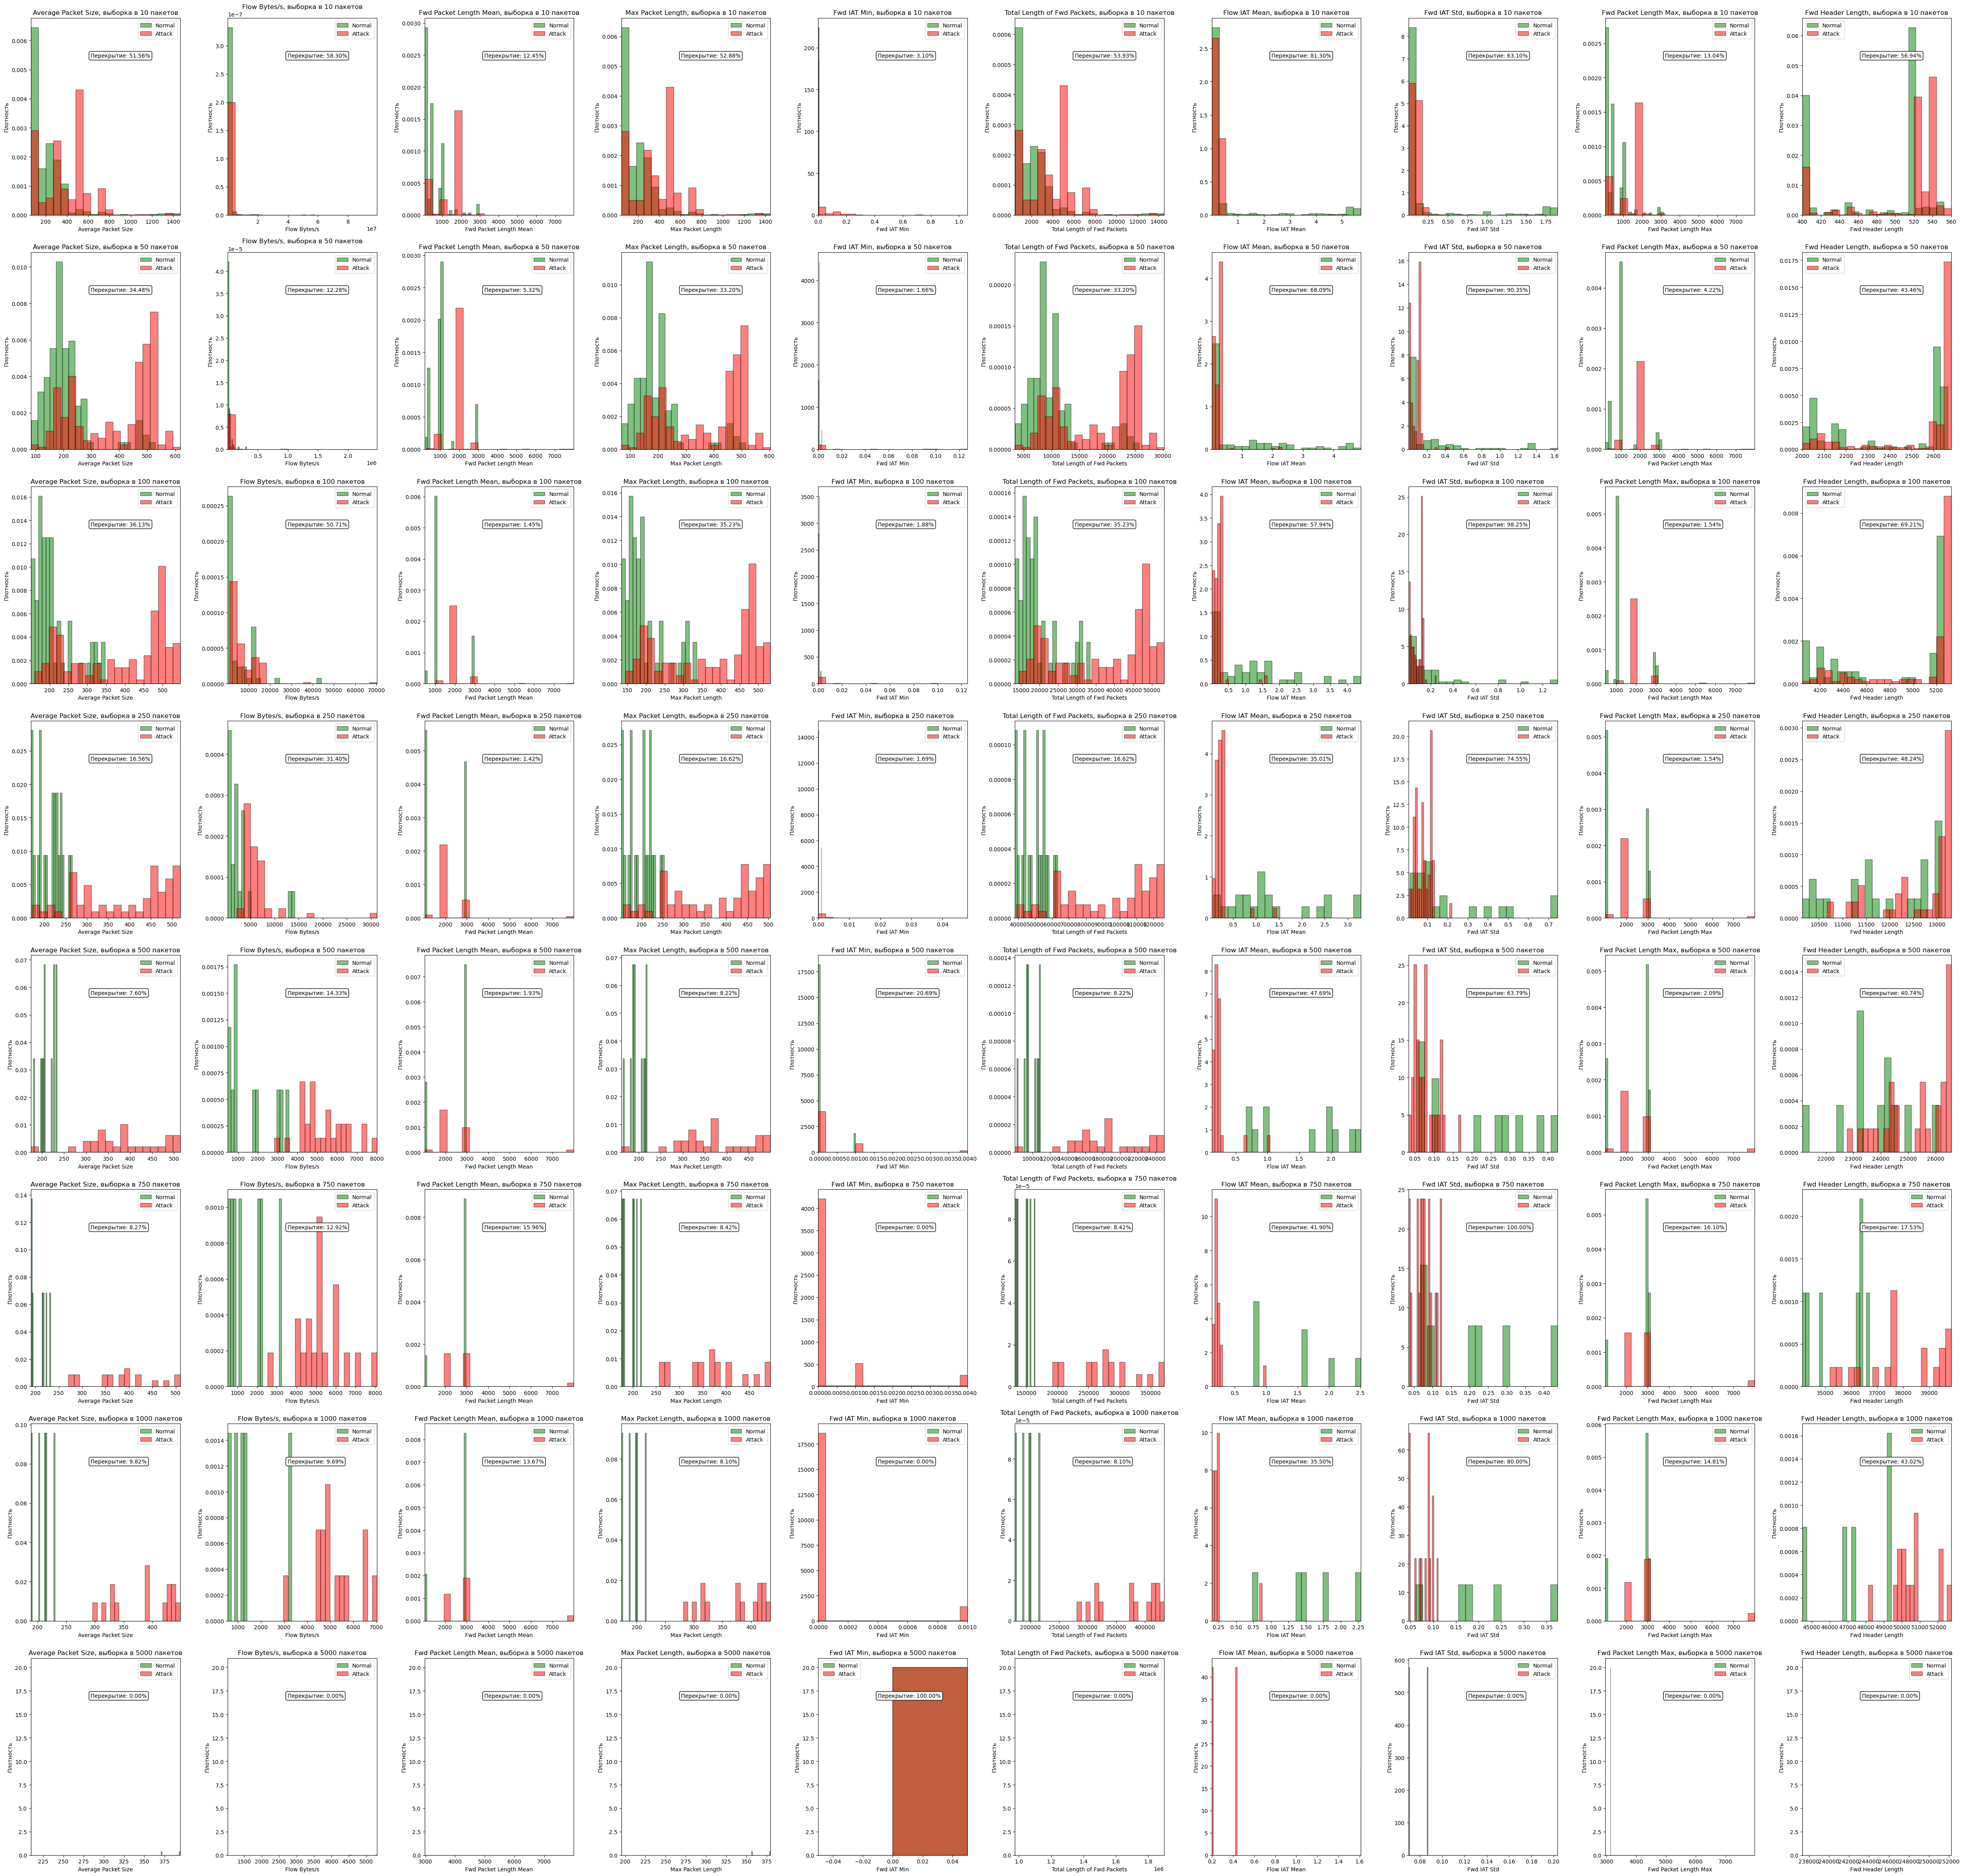

In [13]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import numpy as np


def plot_histograms_for_pairs(attack_dir, normal_dir):
    # Словарь для хранения пар файлов по длине выборки
    pairs = defaultdict(lambda: {"attack": [], "normal": []})

    # Сопоставление файлов из папки attack и normal по длине выборки
    for file in os.listdir(attack_dir):
        if "_1_" in file:
            length = int(file.split("_")[-3])
            pairs[length]["attack"].append(file)

    for file in os.listdir(normal_dir):
        if "_0_" in file:
            length = int(file.split("_")[-3])
            pairs[length]["normal"].append(file)

    # Подсчет общего количества наборов
    total_pairs = 0

    # Определение столбцов на основе первого набора данных
    for length, file_pairs in pairs.items():
        attack_file = sorted(file_pairs["attack"])
        normal_file = sorted(file_pairs["normal"])

        # Убедимся, что количество парных файлов совпадает
        if len(attack_file) == len(normal_file):
            attack_path = os.path.join(attack_dir, attack_file[0])

            # Загрузка данных из файлов CSV
            df_attack = pd.read_csv(attack_path)

            # Получаем список всех столбцов, кроме 'Label' и 'Index'
            columns = [
                col for col in df_attack.columns if col not in ["Label", "Index"]
            ]
            # Считаем, сколько будет строк из горизонтальных подграфиков в итоговом полотне
            total_pairs += 1

    # Создание общего полотна для всех пар файлов
    fig, axes = plt.subplots(
        total_pairs, len(columns), figsize=(5 * len(columns), 6 * total_pairs)
    )

    # Индекс для строк подграфиков
    row_idx = 0

    # Построение графиков для каждого набора пар
    for length, file_pairs in sorted(pairs.items()):
        attack_file = sorted(file_pairs["attack"])
        normal_file = sorted(file_pairs["normal"])

        # Убедимся, что количество парных файлов совпадает
        if len(attack_file) == len(normal_file):
            attack_path = os.path.join(attack_dir, attack_file[0])
            normal_path = os.path.join(normal_dir, normal_file[0])

            # Загрузка данных из файлов CSV
            df_attack = pd.read_csv(attack_path)
            df_normal = pd.read_csv(normal_path)

            # Создание подграфиков в строке
            for col_idx, column in enumerate(columns):
                # Получение минимальных и максимальных значений для нормализации масштаба оси X
                min_val = min(df_normal[column].min(), df_attack[column].min())
                max_val = max(df_normal[column].max(), df_attack[column].max())

                # Построение гистограмм
                hist_normal, bins_normal = np.histogram(
                    df_normal[column], bins=20, density=True
                )
                hist_attack, bins_attack = np.histogram(
                    df_attack[column], bins=20, density=True
                )

                # Вычисление перекрытия
                overlap_area = np.sum(np.minimum(hist_normal, hist_attack)) * (
                    bins_normal[1] - bins_normal[0]
                )

                # Подсчет процентного соотношения перекрытия
                percent_overlap = (
                    overlap_area * 100
                )  # Умножаем на 100 для получения процента

                # Отображение гистограмм с границами столбцов
                axes[row_idx, col_idx].hist(
                    df_normal[column],
                    bins=20,
                    color="green",
                    alpha=0.5,
                    label="Normal",
                    density=True,
                    edgecolor="black",
                )
                axes[row_idx, col_idx].hist(
                    df_attack[column],
                    bins=20,
                    color="red",
                    alpha=0.5,
                    label="Attack",
                    density=True,
                    edgecolor="black",
                )

                # Установим общие границы по оси X для нормализации
                axes[row_idx, col_idx].set_xlim(min_val, max_val)
                axes[row_idx, col_idx].set_title(
                    f"{column}, выборка в {length} пакетов"
                )
                axes[row_idx, col_idx].set_xlabel(column)
                axes[row_idx, col_idx].set_ylabel("Плотность")

                # Добавление аннотации о проценте перекрытия
                axes[row_idx, col_idx].annotate(
                    f"Перекрытие: {percent_overlap:.2f}%",
                    xy=(0.4, 0.8),
                    xycoords="axes fraction",
                    fontsize=10,
                    bbox=dict(
                        facecolor="white", edgecolor="black", boxstyle="round,pad=0.3"
                    ),
                )

                # Добавление легенды
                axes[row_idx, col_idx].legend()

            row_idx += 1  # Переходим к следующей паре

    # Устанавливаем плотное расположение графиков
    plt.tight_layout()

    # Показать все графики на общем полотне
    plt.show()


# Пример использования функции
attack_dir = "csvs/xss/attack/"
normal_dir = "csvs/xss/normal/"
plot_histograms_for_pairs(attack_dir, normal_dir)